In [1]:
import pandas as pd
df = pd.read_csv(r"C:\Users\hi\Desktop\Data Analytics\Data Sets\new\python_learning_exam_performance.csv")
df = df.dropna().reset_index()
df = df.drop(columns=['index'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1938 entries, 0 to 1937
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   student_id                         1938 non-null   int64  
 1   age                                1938 non-null   int64  
 2   country                            1938 non-null   object 
 3   prior_programming_experience       1938 non-null   object 
 4   weeks_in_course                    1938 non-null   int64  
 5   hours_spent_learning_per_week      1938 non-null   float64
 6   practice_problems_solved           1938 non-null   int64  
 7   projects_completed                 1938 non-null   int64  
 8   tutorial_videos_watched            1938 non-null   int64  
 9   uses_kaggle                        1938 non-null   int64  
 10  participates_in_discussion_forums  1938 non-null   int64  
 11  debugging_sessions_per_week        1938 non-null   int64

In [14]:
#imports
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report

In [3]:
# splitting the dataset
X = df.drop(['student_id','final_exam_score','passed_exam'], axis=1)
y = df['passed_exam']

In [4]:
# encoding cat columns

le = LabelEncoder()
X['country'] = le.fit_transform(X.country)
X['prior_programming_experience'] = le.fit_transform(X.prior_programming_experience)

In [5]:
num_col = X.select_dtypes('int64','float64').columns
num_col

Index(['age', 'country', 'prior_programming_experience', 'weeks_in_course',
       'practice_problems_solved', 'projects_completed',
       'tutorial_videos_watched', 'uses_kaggle',
       'participates_in_discussion_forums', 'debugging_sessions_per_week',
       'self_reported_confidence_python'],
      dtype='object')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [7]:
preprocessing = ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),num_col)
    ]
)

In [8]:
# creating the base models
base_models =[
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)),
    ('xgb', XGBClassifier(random_state=42, eval_metric='logloss')),
    ('lr', LogisticRegression(max_iter=1000))
]

In [9]:
#creating a meta model
final_estimator = LogisticRegression(max_iter=1000)

meta_model = StackingClassifier(
    estimators = base_models,
    final_estimator = final_estimator,
    cv=5,
    n_jobs=-1
)



In [10]:
#creating final model containing all steps
model = Pipeline(
    steps=[
        ('preprocessing',preprocessing),
        ('smote', SMOTE(random_state=42)),
        ('classifier', meta_model)
    ]
)

In [11]:
#training the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'country', 'prior_programming_experience', 'weeks_in_course',
       'practice_problems_solved', 'projects_completed',
       'tutorial_videos_watched', 'uses_kaggle',
       'participates_in_discussion_forums', 'debugging_sessions_per_week',
       'self_reported_confidence_python'],...
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=None,
                                                               n_jobs=None,
                                                               num_parallel_tree=None, ...)),
                                                ('lr',
                                                 LogisticRegression(max_iter=1000))],
                                    final_estimator=LogisticRegression(max_iter=1000),
                                    n_jobs=-1))])

In [13]:
y_pred = model.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89       295
           1       0.64      0.66      0.65        93

    accuracy                           0.83       388
   macro avg       0.77      0.77      0.77       388
weighted avg       0.83      0.83      0.83       388



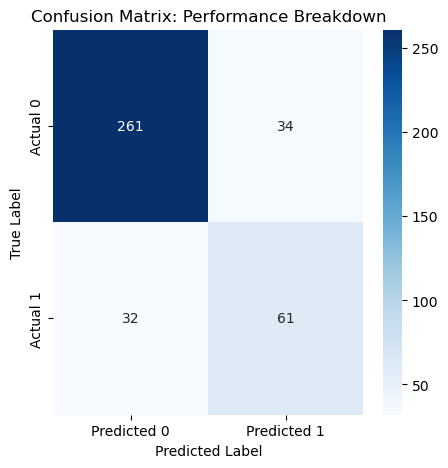

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Generate the confusion matrix data
cm = confusion_matrix(y_test, y_pred)

# 2. Plotting
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Performance Breakdown')
plt.show()